In [2]:
import numpy as np, matplotlib.pyplot as plt
from math import pi

Параметры заданные п:

$$ c = 1,65 $$
$$ k = 0,59 $$
$$ R = 5 $$
$$ u_c = 0 $$
$$ l = 0,5 $$
$$ \alpha = 0,003 $$
$$ T = 40 $$
$$ \psi(\theta) = u_c + cos^4 (\theta) $$

In [4]:
c = 1.65
k = 0.59
R = 5
uc = 0
l = 0.5
alpha = 0.003
T = 40

def psi(theta):
    return uc + np.cos(theta) ** 4

I = 512
K = 512
t = np.linspace(0, T, K + 1)
tht = np.linspace(0.001, pi-0.001, I + 1)

Начальное распределение температуры:

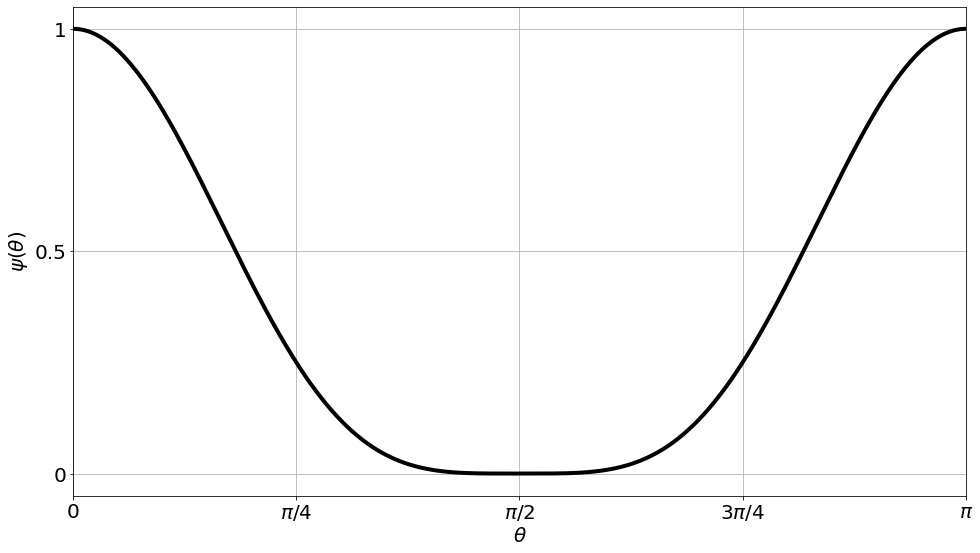

In [3]:
f = plt.figure(figsize=[16, 9])
plt.plot(tht, psi(tht), lw=4, c='black')
plt.xlim([tht[1], tht[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${\\psi(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=20)
plt.grid()
plt.show()

In [5]:
ht = t[2] - t[1]
htht = tht[2] - tht[1]

In [6]:
A = k / (c * R ** 2)
B = alpha / (c * l)

gam = -A * ht / (htht ** 2) * (1 + htht / (2 * np.tan(tht[:-1])))
eps = -A * ht / (htht ** 2) * (1 - htht / (2 * np.tan(tht[1:])))

eta = B * ht * uc

mu = B * ht + 4 * A * ht / (htht ** 2) + 1
sigma = - 2 * A * ht / (htht ** 2) 

beta = (B * ht + 2 * A * ht / (htht ** 2) + 1) * np.ones(I + 1)
eps[-1] = sigma
gam[0] = sigma


In [7]:
v = np.zeros([K + 1, I + 1])
v[0, :] = psi(tht)

In [8]:
import time

In [8]:
matrix = np.diag(beta) + np.diag(eps, -1) + np.diag(gam, 1)

t_from = time.time()

for k_ind in range(1,K+1):
    v[k_ind, :] = np.linalg.inv(matrix) @ v[k_ind - 1, :]

t_matrix = time.time() - t_from
print('Время для матричного метода: ', str(t_matrix), ' сек')

Время для матричного метода:  8.944020509719849  сек


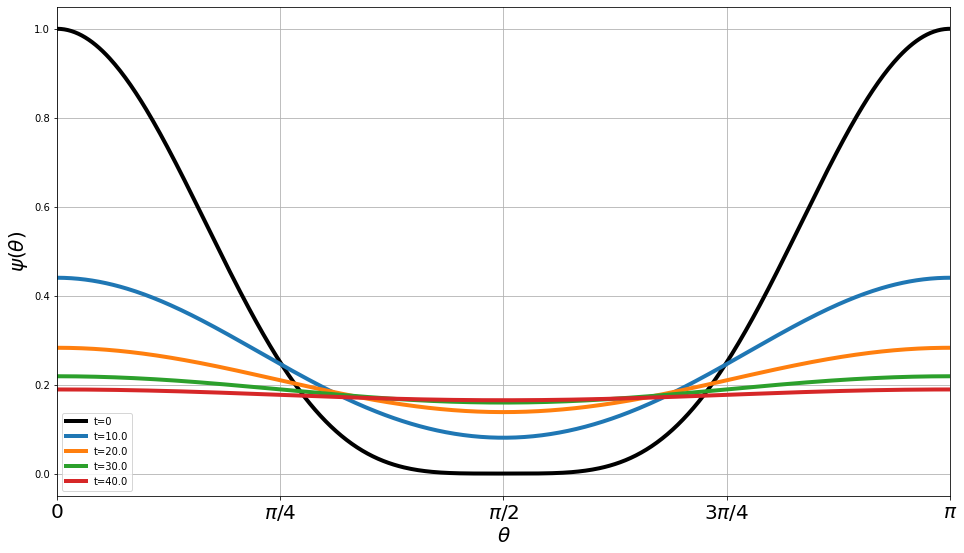

In [9]:
f = plt.figure(figsize=[16, 9])
plt.plot(tht, v[0, :], lw=4, c='black', label='t=0')
for ind in [int(K / 4), int(K / 2), int(3 * K / 4), K]:
    plt.plot(tht, v[ind, :], lw=4, label='t='+str(t[ind]))

plt.xlim([tht[1], tht[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${\\psi(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
# plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=20)
plt.legend()
plt.grid()
plt.show()

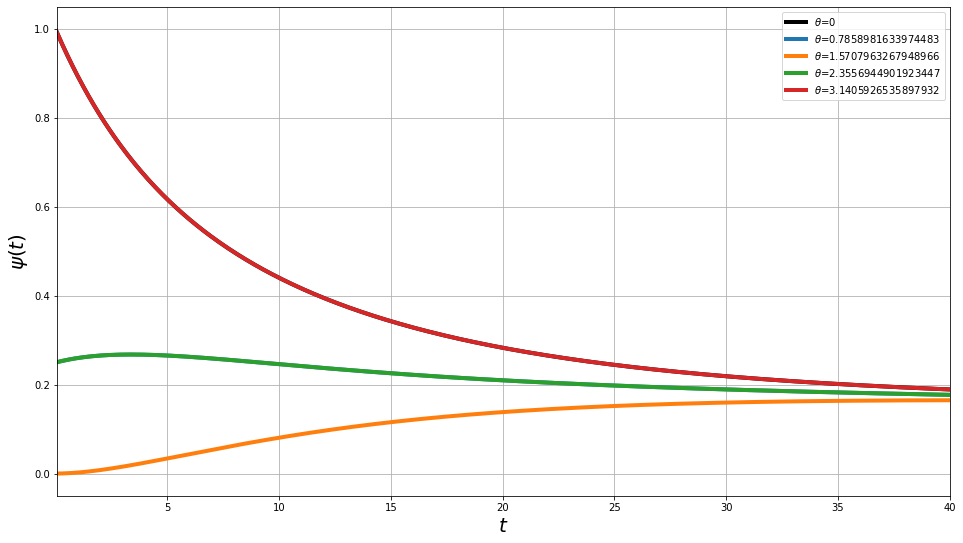

In [10]:
f = plt.figure(figsize=[16, 9])
plt.plot(t, v[:, 0], lw=4, c='black', label='$\\theta$=0')
for ind in [int(I / 4), int(I / 2), int(3 * I / 4), I]:
    plt.plot(t, v[:, ind], lw=4, label='$\\theta$='+str(tht[ind]))
plt.xlim([t[1], t[-1]])
plt.xlabel('$t$', fontsize=20)
plt.ylabel('${\\psi(t)}$', fontsize=20)
plt.legend()
plt.grid()
plt.show()

Простейшая неявная схема

**Реализация алгоритма прогонки**

$$ \begin{pmatrix}
c_1 & b_1 & 0 & ... & 0\\
a_2 & c_2 & b_2 & ... & 0 \\
\vdots &  & \ddots &  & \vdots \\
0 & ... & a_{n-1} & c_{n-1} & b_{n-1} \\
0 & ... & 0 & a_n & c_n \\
\end{pmatrix}
\begin{pmatrix}
x_1\\
x_2\\
\vdots\\
x_{n-1}\\
x_n\\
\end{pmatrix}
=
\begin{pmatrix}
f_1\\
f_2\\
\vdots\\
f_{n-1}\\
f_n\\
\end{pmatrix}
$$

Прямой ход:
$$
\xi_n = - a_n / c_n, 
$$
$$
\xi_i = - \frac{a_i}{c_i + b_i \xi_{i+1}}, i = n-1,...,2
$$
$$
\eta_n = f_n / c_n, 
$$
$$
\eta_i = \frac{f_i - b_i \eta_{i+1}}{c_i + b_i \xi_{i+1}}, i = n-1,...,2
$$
Обратный ход:
$$
x_1 = \frac{f_1 - b_1 \eta_2}{b_1 \xi_2 + c_1}
$$
$$
x_{i+1} = \xi_{i+1} x_i + \eta_{i+1}, i = 1,...,n-1
$$


In [15]:
def tri_diag_solver_left(a, c, b, f):
    n = c.size
    k = n - 1
    xsi = np.zeros(k)
    eta = np.zeros(k)
    x = np.zeros(n)
    
    xsi[-1] = - a[-1] / c[-1]
    eta[-1] = f[-1] / c[-1]
    
    for ind in range(k-2, -1, -1):
        xsi[ind] = - a[ind] / (c[ind + 1] + b[ind + 1] * xsi[ind + 1])
        eta[ind] = (f[ind + 1] - b[ind + 1] * eta[ind + 1]) / (c[ind + 1] + b[ind + 1] * xsi[ind + 1])
    x[0] = (f[0] - b[0] * eta[0]) / (b[0] * eta[0] + c[0])
    
    for ind in range(1, n):
        x[ind] = xsi[ind - 1] * x[ind - 1] + eta[ind - 1]
    return x

In [16]:
def tri_diag_solver_right(a, c, b, f):
    n = c.size
    k = n - 1
    alpha = np.zeros(k)
    beta = np.zeros(k)
    x = np.zeros(n)
    
    alpha[0] = - b[0] / c[0]
    beta[0] = f[0] / c[0]
    
    for ind in range(1, k):
        alpha[ind] = - b[ind] / (a[ind - 1] * alpha[ind - 1] + c[ind])
        beta[ind] = (f[ind] - a[ind - 1] * beta[ind - 1]) / (a[ind - 1] * alpha[ind - 1] + c[ind])
        
    x[-1] = (f[-1] - a[-1] * beta[-1]) / (a[-1] * alpha[-1] + c[-1])
    
    for ind in range(n - 2, -1, -1):
        x[ind] = alpha[ind] * x[ind + 1] + beta[ind]
    return x

In [17]:
v_prog = np.zeros([K + 1, I + 1])
v_prog[0, :] = psi(tht)

t_from = time.time()
for k_ind in range(1,K+1):
    v_prog[k_ind, :] = tri_diag_solver_right(eps, beta, gam, v_prog[k_ind - 1, :])
    
t_tridiag = time.time() - t_from
print('Время для метода прогнки: ' + str(t_tridiag) + ' ceк')

Время для метода прогнки: 1.4009935855865479 ceк


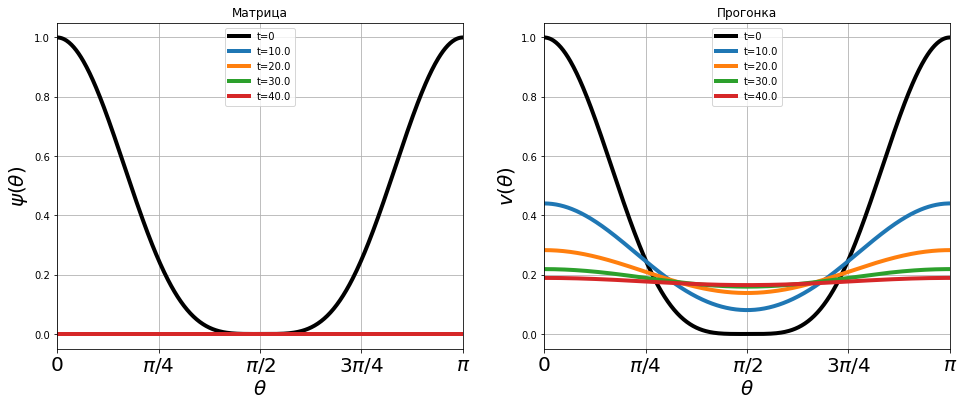

In [18]:
f = plt.figure(figsize=[16, 6])

plt.subplot(1, 2, 1)
plt.plot(tht, v[0, :], lw=4, c='black', label='t=0')
for ind in [int(K / 4), int(K / 2), int(3 * K / 4), K]:
    plt.plot(tht, v[ind, :], lw=4, label='t='+str(t[ind]))

plt.xlim([tht[1], tht[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${\\psi(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
# plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=20)
plt.legend()
plt.grid()
plt.title('Матрица')

plt.subplot(1, 2, 2)
plt.plot(tht, v_prog[0, :], lw=4, c='black', label='t=0')
for ind in [int(K / 4), int(K / 2), int(3 * K / 4), K]:
    plt.plot(tht, v_prog[ind, :], lw=4, label='t='+str(t[ind]))

plt.xlim([tht[1], tht[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${v(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
# plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=20)
plt.legend()
plt.grid()
plt.title('Прогонка')
plt.show()

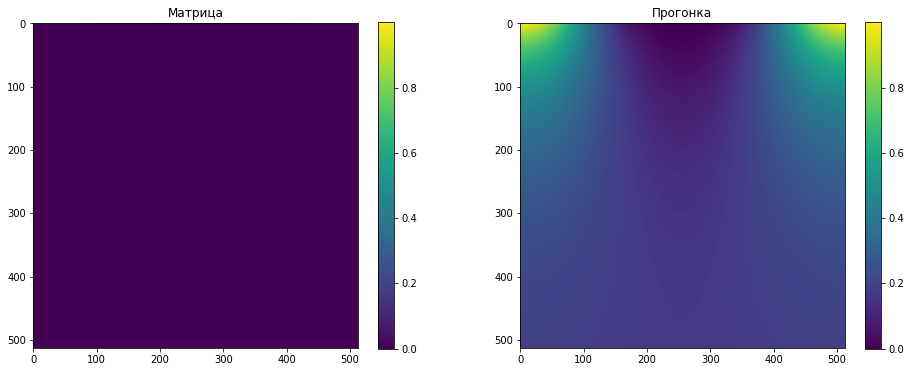

In [19]:
f = plt.figure(figsize=[16, 6])
plt.subplot(1, 2, 1)
plt.imshow(v)
plt.colorbar()
plt.title('Матрица')
plt.subplot(1, 2, 2)
plt.imshow(v_prog)
plt.colorbar()
plt.title('Прогонка')
plt.show()

Отклонение решения м. прогонки и матричным методом

In [20]:
print(sum(sum(np.abs(v_prog - v) ** 2)))

18282.62488044208


In [21]:
print('м. прогонки быстрее матричного м. в ' + str(round(t_matrix / t_tridiag)) + ' раз(-а)')

NameError: name 't_matrix' is not defined

Выберем некоторый момент времени, например t=10 sec

In [22]:
import random
ls_list = [':', '-', '--', '-.']

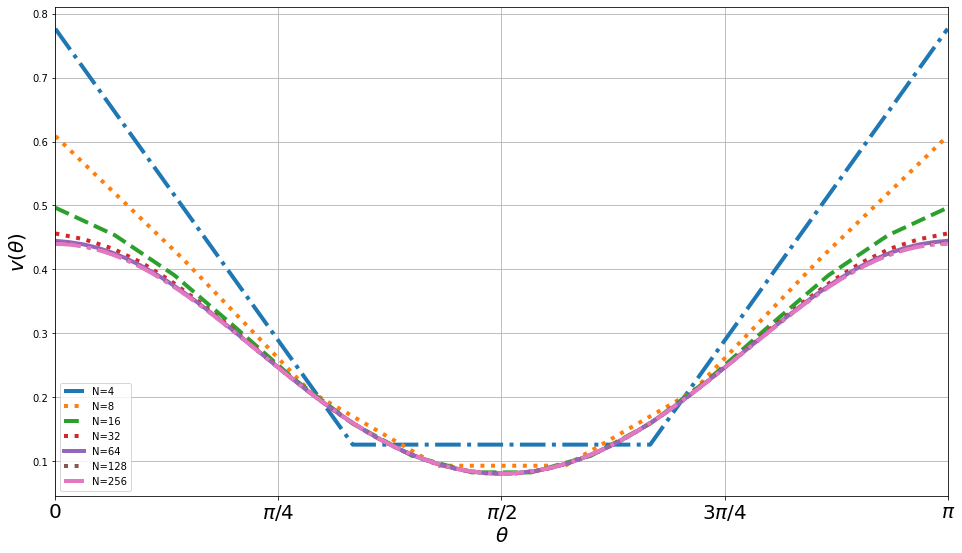

In [23]:
f = plt.figure(figsize=[16, 9])
for i in [3, 7, 15, 31, 63, 127, 255]:
    t10s = np.linspace(0, 10, i + 1)
    tht = np.linspace(0.001, pi-0.001, i + 1)
    ht = t10s[2] - t10s[1]
    htht = tht[2] - tht[1]
    
    gam = -A * ht / (htht ** 2) * (1 + htht / (2 * np.tan(tht[:-1])))
    eps = -A * ht / (htht ** 2) * (1 - htht / (2 * np.tan(tht[1:])))

    eta = B * ht * uc

    mu = B * ht + 4 * A * ht / (htht ** 2) + 1
    sigma = - 2 * A * ht / (htht ** 2) 

    beta = (B * ht + 2 * A * ht / (htht ** 2) + 1) * np.ones(i + 1)
    eps[-1] = sigma
    gam[0] = sigma
    
    
    v_10s = np.zeros([i + 1, i + 1])
    v_10s[0, :] = psi(tht)

    t_from = time.time()
    for k_ind in range(1,i+1):
        v_10s[k_ind, :] = tri_diag_solver_right(eps, beta, gam, v_10s[k_ind - 1, :])
    
    plt.plot(tht, v_10s[-1, :], lw=4, ls=random.choice(ls_list), label='N=' + str(i + 1))

plt.xlim([tht[1], tht[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${v(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
plt.legend()
plt.grid()
plt.show()

Явная схема

In [9]:
I_anton = 512
K_anton = I_anton*64
print('K/I =', K_anton/I_anton)
t_anton = np.linspace(0, T, K_anton + 1)
tht_anton = np.linspace(0.001, pi-0.001, I_anton + 1)
ht_anton = t_anton[2] - t_anton[1]
htht_anton = tht_anton[2] - tht_anton[1]

K/I = 64.0


In [10]:
v_ex = np.zeros([K_anton + 1, I_anton + 1])
v_ex[0, :] = psi(tht_anton)

In [11]:
triangle = k * ht_anton / (R ** 2) / c / (htht_anton ** 2)
circle = alpha * ht_anton / l / c
square = k * ht_anton / (R ** 2) / np.tan(tht_anton) / 2 / htht_anton / c

In [25]:
t0_ex = time.time()
for k_ind in range(1, K_anton + 1):
    v_ex[k_ind, 0] = (1 - circle - 2 * triangle) * v_ex[k_ind - 1, 0] + 2 * triangle * (v_ex[k_ind - 1, 1])
    for i_ind in range(1, I_anton):
        v_ex[k_ind, i_ind] = (1 - 2 * triangle - circle) * v_ex[k_ind - 1, i_ind] + (square[i_ind] + triangle) * v_ex[k_ind - 1, i_ind + 1] + (triangle - square[i_ind]) * v_ex[k_ind - 1, i_ind - 1]
    v_ex[k_ind, I_anton] = (1 - circle - 2 * triangle) * v_ex[k_ind - 1, I_anton] + 2 * triangle * (v_ex[k_ind - 1, I_anton - 1])
print('Время подсчета: ', time.time() - t0_ex)

C:\Users\Антон\AppData\Local\Temp\ipykernel_4184\3824092020.py:3: RuntimeWarning: overflow encountered in double_scalars
  v_ex[k_ind, 0] = (1 - circle - 4 * triangle) * v_ex[k_ind - 1, 0] + 2 * triangle * (v_ex[k_ind - 1, 1])
C:\Users\Антон\AppData\Local\Temp\ipykernel_4184\3824092020.py:6: RuntimeWarning: overflow encountered in double_scalars
  v_ex[k_ind, I_anton] = (1 - circle - 4 * triangle) * v_ex[k_ind - 1, I_anton] + 2 * triangle * (v_ex[k_ind - 1, I_anton - 1])
C:\Users\Антон\AppData\Local\Temp\ipykernel_4184\3824092020.py:5: RuntimeWarning: invalid value encountered in double_scalars
  v_ex[k_ind, i_ind] = (1 - 2 * triangle - circle) * v_ex[k_ind - 1, i_ind] + (square[i_ind] + triangle) * v_ex[k_ind - 1, i_ind + 1] + (triangle - square[i_ind]) * v_ex[k_ind - 1, i_ind - 1]


Время подсчета:  80.7437493801117


Отклонение от неявной схемы для t = 10.0 = 0.0001657282730975802
Отклонение от неявной схемы для t = 20.0 = 6.986378801140041e-05
Отклонение от неявной схемы для t = 30.0 = 2.495008444782062e-05
Отклонение от неявной схемы для t = 40.0 = 7.489653096498472e-06


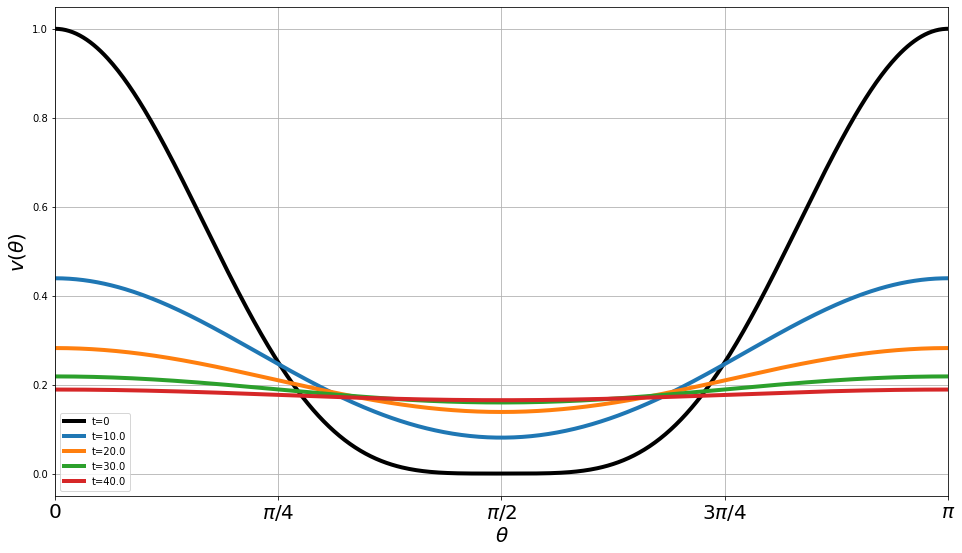

In [24]:
f = plt.figure(figsize=[16, 9])
plt.plot(tht_anton, v_ex[0, :], lw=4, c='black', label='t=0')
for coef in [1/4, 1/2, 3/4, 1]:
    plt.plot(tht_anton, v_ex[int(K_anton * coef), :], lw=4, label='t='+str(t_anton[int(K_anton * coef)]))
    print('Отклонение от неявной схемы для t =', t_anton[int(K_anton * coef)], '=', sum(np.abs(v_ex[int(K_anton * coef), :] - v_prog[int(K * coef), :]) ** 2))

plt.xlim([tht_anton[1], tht_anton[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${v(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
# plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=20)
plt.legend()
plt.grid()
plt.show()

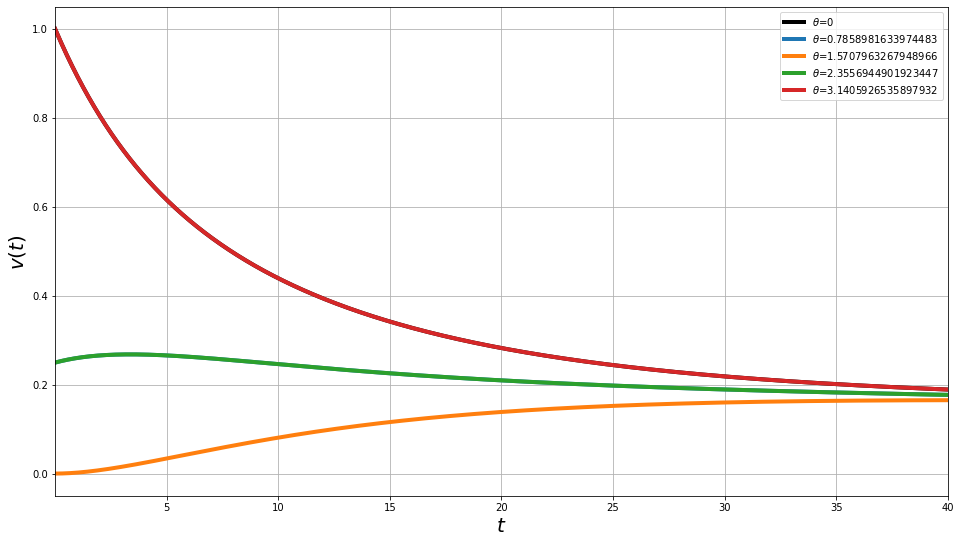

In [14]:
f = plt.figure(figsize=[16, 9])
plt.plot(t_anton, v_ex[:, 0], lw=4, c='black', label='$\\theta$=0')
for ind in [int(I_anton / 4), int(I_anton / 2), int(3 * I_anton / 4), I_anton]:
    plt.plot(t_anton, v_ex[:, ind], lw=4, label='$\\theta$='+str(tht_anton[ind]))
plt.xlim([t_anton[1], t_anton[-1]])
plt.xlabel('$t$', fontsize=20)
plt.ylabel('${v(t)}$', fontsize=20)
plt.legend()
plt.grid()
plt.show()

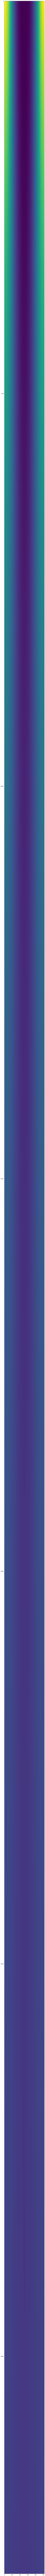

In [26]:
f = plt.figure(figsize=[64, 500])
plt.imshow(v_ex)
plt.show()